<a href="https://colab.research.google.com/github/rhqrhq/Adversarial_Examples_Papers/blob/main/pTRpred.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install --upgrade pandas


In [4]:
pip install pmdarima

In [6]:
pip install numpy==1.26.4


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 147.7 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.3 which is incompatible.
dask-cudf-cu12 25.6.0 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.3 which is incompatible.
jaxlib 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
jax 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
pytensor 2.35.1 requires n

In [1]:
import pmdarima

In [2]:
# roll_windows
from typing import Sequence, Literal
import numpy as np
import pandas as pd

def roll_windows(
    time: Sequence,
    window: int,
    step: int = 1,
    align: Literal["end", "center", "start"] = "end",
    type: Literal["rolling", "expanding"] = "rolling",
) -> pd.DataFrame:
    """
    Build rolling / expanding window indices over a time vector.
    """
    if window < 1:
        raise ValueError("`window` must be >= 1")
    if step < 1:
        raise ValueError("`step` must be >= 1")

    align = align.lower()
    if align not in {"end", "center", "start"}:
        raise ValueError("`align` must be one of {'end','center','start'}")

    type = type.lower()
    if type not in {"rolling", "expanding"}:
        raise ValueError("`type` must be one of {'rolling','expanding'}")

    ts = pd.Series(time)
    n = len(ts)

    if type == "rolling":
        if n < window:
            starts = np.array([1], dtype=int)
            ends   = np.array([n], dtype=int)
        else:
            starts = np.arange(1, n - window + 2, step, dtype=int)
            ends   = starts + window - 1
    else:
        if n < window:
            ends = np.array([n], dtype=int)
        else:
            ends = np.arange(window, n + 1, step, dtype=int)
            if ends.size == 0:
                ends = np.array([n], dtype=int)
        starts = np.full_like(ends, 1)

    if align == "end":
        t_rep_idx_1b = ends
    elif align == "start":
        t_rep_idx_1b = starts
    else:
        t_rep_idx_1b = np.floor((starts + ends) / 2).astype(int)

    t_rep = ts.iloc[t_rep_idx_1b - 1].to_numpy()
    idx_list = [list(range(int(s), int(e) + 1)) for s, e in zip(starts, ends)]

    out = pd.DataFrame({
        "window_id": np.arange(1, len(starts) + 1, dtype=int),
        "start": starts,
        "end": ends,
        "t_rep": t_rep,
        "idx": idx_list,
    })
    return out

In [3]:
# extract_X
import pandas as pd
from typing import Sequence, Union

def extract_X(data: pd.DataFrame, x_cols: Union[Sequence[str], str]) -> pd.DataFrame:
    """
    Extract a numeric matrix (as a pandas DataFrame) from a data frame.

    Parameters
    ----------
    data : pd.DataFrame
        Must contain the columns of interest.
    x_cols : list of str or str
        - A list of exact column names, e.g. ["temp1","temp2"]
        - A single regex string containing '|' to match multiple names, e.g. "temp|volt"

    Returns
    -------
    pd.DataFrame
        Numeric DataFrame with preserved column names.
    """
    if not isinstance(data, pd.DataFrame):
        raise ValueError("`data` must be a pandas DataFrame.")

    if isinstance(x_cols, str):
        if "|" in x_cols:
            keep = data.filter(regex=x_cols).columns.tolist()
        else:
            keep = [x_cols]
    elif isinstance(x_cols, (list, tuple)):
        keep = list(x_cols)
    else:
        raise ValueError("`x_cols` must be a list of names or a single regex string.")

    if len(keep) == 0:
        raise ValueError("No columns selected by `x_cols`.")

    X = data.loc[:, keep].copy()
    for c in keep:
        X[c] = pd.to_numeric(X[c], errors="coerce")

    return X

In [4]:
# na_handle
import numpy as np
import pandas as pd
from typing import Literal, Union

def na_handle(
    M: Union[np.ndarray, pd.DataFrame],
    method: Literal["omit_rows","impute_mean","pairwise_complete"] = "omit_rows"
) -> np.ndarray:
    """
    Simple NA handling for numeric matrices.

    Parameters
    ----------
    M : array-like (numpy array or pandas DataFrame)
        Numeric-like object.
    method : {"omit_rows","impute_mean","pairwise_complete"}
        - "omit_rows": drop any rows containing NaN
        - "impute_mean": impute NaNs with column means (if >=2 non-NA values)
        - "pairwise_complete": leave NAs as-is

    Returns
    -------
    numpy.ndarray
        Numeric matrix with NAs handled.
    """
    if isinstance(M, pd.DataFrame):
        A = M.to_numpy(dtype=float)
    else:
        A = np.asarray(M, dtype=float)

    if method == "omit_rows":
        mask = ~np.isnan(A).any(axis=1)
        return A[mask, :]

    if method == "impute_mean":
        A_copy = A.copy()
        for j in range(A_copy.shape[1]):
            col = A_copy[:, j]
            nan_mask = np.isnan(col)
            if not nan_mask.any():
                continue
            n_non_na = np.sum(~nan_mask)
            if n_non_na <= 1:
                # 0 or 1 observed values -> leave NaNs as NaN
                continue
            m = np.nanmean(col)
            A_copy[nan_mask, j] = m
        return A_copy

    if method == "pairwise_complete":
        return A

    raise ValueError("`method` must be one of {'omit_rows','impute_mean','pairwise_complete'}")

In [5]:
# roll_svd
from typing import List, Optional, Sequence, Literal, Dict, Any
import numpy as np
import pandas as pd

# Assumes roll_windows, extract_X, and na_handle are already defined.

def _cov_window(
    Xc: pd.DataFrame,
    na_action: Literal["omit_rows","impute_mean","pairwise_complete"],
    cov_on_pairwise: bool
) -> np.ndarray:
    """
    Compute covariance for a single window, honoring pairwise-complete option.
    Returns a (p x p) numpy array.
    """
    if na_action == "pairwise_complete" and cov_on_pairwise:
        S = Xc.cov(min_periods=2)  # pairwise complete by default
        return S.to_numpy()
    else:
        Xc2 = Xc.dropna(axis=0, how="any")
        if Xc2.shape[0] < 2:
            return np.full((Xc.shape[1], Xc.shape[1]), np.nan, dtype=float)
        return np.cov(Xc2.to_numpy(), rowvar=False, ddof=1)

def roll_svd(
    data: pd.DataFrame,
    time: str,
    x_cols: Sequence[str] | str,
    window: int,
    step: int = 1,
    align: Literal["end", "center", "start"] = "end",
    type: Literal["rolling", "expanding"] = "rolling",
    center: bool = True,
    scale_: bool = False,
    k: Optional[int] = None,
    fast: bool = True,
    na_action: Literal["omit_rows","impute_mean","pairwise_complete"] = "omit_rows",
    cov_on_pairwise: bool = True,
    values_only: bool = True,
    seed: Optional[int] = None,
) -> Dict[str, Any]:
    """
    Rolling SVD (eigendecomposition) of per-window covariance.

    Returns a dict with:
      - windows   : DataFrame from roll_windows (one row per window)
      - D         : list of 1D numpy arrays (eigenvalues per window)
      - V         : list of (p x k) numpy arrays (eigenvectors) or None if values_only
      - U_scores  : list of (n_w x k) numpy arrays (standardized scores) or None if values_only
      - k         : requested k (or None if not set)
      - colnames  : list of feature names
      - preproc   : {'center': bool, 'scale.': bool}
      - values_only : bool
    """
    if time not in data.columns:
        raise ValueError("`time` must be a column in `data`.")
    if seed is not None:
        np.random.seed(seed)

    windows = roll_windows(data[time].to_numpy(), window, step, align, type)
    X_all = extract_X(data, x_cols)
    colnames = list(X_all.columns)
    p = X_all.shape[1]

    nW = windows.shape[0]
    D_list: List[Optional[np.ndarray]] = [None] * nW
    V_list: Optional[List[Optional[np.ndarray]]] = None if values_only else [None] * nW
    U_list: Optional[List[Optional[np.ndarray]]] = None if values_only else [None] * nW

    _have_scipy = False
    if fast:
        try:
            from scipy.sparse.linalg import eigsh  # type: ignore
            _have_scipy = True
        except Exception:
            _have_scipy = False

    for w in range(nW):
        idx_1b = windows.iloc[w]["idx"]          # list of 1-based indices
        idx_0b = [i - 1 for i in idx_1b]         # convert to 0-based
        Xw = X_all.iloc[idx_0b, :].copy()

        # NA handling (per window)
        if na_action == "omit_rows":
            Xw = Xw.dropna(axis=0, how="any")
        elif na_action == "impute_mean":
            Xw = Xw.copy()
            for c in Xw.columns:
                arr = Xw[c].to_numpy()
                nan_mask = np.isnan(arr)
                if nan_mask.any():
                    n_non_na = (~nan_mask).sum()
                    if n_non_na > 1:
                        Xw.loc[nan_mask, c] = np.nanmean(arr)
        elif na_action == "pairwise_complete":
            pass
        else:
            raise ValueError("`na_action` must be one of {'omit_rows','impute_mean','pairwise_complete'}")

        n_w = Xw.shape[0]
        if n_w < 2:
            continue  # skip this window; entries remain None

        # Center/scale per window
        if center:
            mu = Xw.mean(axis=0, skipna=True)
        else:
            mu = pd.Series(np.zeros(p), index=Xw.columns)

        if scale_:
            sc = Xw.std(axis=0, ddof=1, skipna=True).replace(0, np.nan)
        else:
            sc = pd.Series(np.ones(p), index=Xw.columns)

        sc = sc.fillna(1.0)
        Xc = (Xw - mu) / sc

        # Effective k for this window
        kk = min(k if k is not None else min(n_w, p), n_w, p)

        # Covariance for this window
        S = _cov_window(Xc, na_action, cov_on_pairwise)
        if not np.isfinite(S).all():
            continue

        if values_only:
            vals = np.linalg.eigvalsh(S)[::-1]  # descending
            D_list[w] = vals[:kk].copy()
        else:
            if _have_scipy and kk < p:
                from scipy.sparse.linalg import eigsh  # type: ignore
                vals, vecs = eigsh(S, k=kk, which="LA")
                order = np.argsort(-vals)
                vals = vals[order]
                vecs = vecs[:, order]
            else:
                vals_full, vecs_full = np.linalg.eigh(S)  # ascending
                order = np.argsort(-vals_full)
                vals = vals_full[order][:kk]
                vecs = vecs_full[:, order][:, :kk]

            D_list[w] = vals.copy()
            V_list[w] = vecs.copy() if V_list is not None else None
            if U_list is not None:
                U_list[w] = Xc.to_numpy() @ vecs

    return {
        "windows": windows,
        "D": D_list,
        "V": V_list,
        "U_scores": U_list,
        "k": (None if k is None else int(k)),
        "colnames": colnames,
        "preproc": {"center": bool(center), "scale.": bool(scale_)},
        "values_only": bool(values_only),
    }

In [6]:
# fit_arimax_vec
import numpy as np
from typing import Optional, Dict, Any
import warnings

def fit_arimax_vec(
    y,
    xreg: Optional[np.ndarray] = None,
    seasonal: bool = True,
    stepwise: bool = True,
    approximation: bool = False,
    **kwargs: Any,
) -> Dict[str, Any]:
    """
    Fit a single ARIMAX model (auto-selected order) and return aligned residuals/fitted.

    Parameters
    ----------
    y : array-like
        Dependent (response) series.
    xreg : array-like, optional
        Exogenous regressors (rows must align with y).
    seasonal : bool, default True
        Passed to pmdarima.auto_arima.
    stepwise : bool, default True
        Passed to pmdarima.auto_arima.
    approximation : bool, default False
        Passed to pmdarima.auto_arima.
    **kwargs :
        Additional arguments forwarded to pmdarima.auto_arima().

    Returns
    -------
    dict with keys:
      - model      : fitted pmdarima model object
      - residuals  : np.ndarray (residuals for the rows used)
      - fitted     : np.ndarray (fitted values for the rows used)
      - mask       : np.ndarray of bools (length len(y)), True where rows were used
    """
    try:
        import pmdarima as pm
    except Exception as e:
        raise ImportError(
            "Package 'pmdarima' is required but not installed. "
            "Install it with: pip install pmdarima"
        ) from e

    y_arr = np.asarray(y, dtype=float).reshape(-1)
    n = y_arr.shape[0]

    if xreg is not None:
        X = np.asarray(xreg, dtype=float)
        if X.ndim == 1:
            X = X.reshape(-1, 1)
        if X.shape[0] != n:
            raise ValueError("`xreg` must have the same number of rows as `y`.")
        ok = np.isfinite(y_arr) & np.isfinite(X).all(axis=1)
        X_used = X[ok, :]
    else:
        ok = np.isfinite(y_arr)
        X_used = None

    if not np.any(ok):
        raise ValueError("No complete cases available for ARIMAX fit.")

    y_used = y_arr[ok]

    # Silence convergence/numerical warnings unless user wants them
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        model = pm.auto_arima(
            y=y_used,
            X=X_used,
            seasonal=seasonal,
            stepwise=stepwise,
            approximation=approximation,
            error_action="warn",
            suppress_warnings=True,
            **kwargs,
        )

    # In-sample predictions and residuals on the used subset
    try:
        fitted_used = model.predict_in_sample(X=X_used)
    except TypeError:
        # older pmdarima signature may use 'exogenous'
        fitted_used = model.predict_in_sample(exogenous=X_used)

    # Some versions expose residuals via .resid(), others via attribute
    try:
        resid_used = model.resid()
    except Exception:
        resid_used = y_used - np.asarray(fitted_used, dtype=float)

    fitted_used = np.asarray(fitted_used, dtype=float).reshape(-1)
    resid_used = np.asarray(resid_used, dtype=float).reshape(-1)

    return {
        "model": model,
        "residuals": resid_used,
        "fitted": fitted_used,
        "mask": ok,
    }

In [20]:
import numpy as np
import pandas as pd
from typing import Sequence, Dict, Any, Optional

# Assumes extract_X(...) and fit_arimax_vec(...) are defined.

def arimax_residuals_df(
    data: pd.DataFrame,
    time: str,
    y_cols: Sequence[str] | str,
    xreg_cols: Sequence[str] | str,
    seasonal: bool = True,
    stepwise: bool = True,
    approximation: bool = False,
    **kwargs: Any,
) -> Dict[str, Any]:
    """
    Batch ARIMAX residuals for multiple series with a common regressor set.

    Returns
    -------
    dict with keys:
      - residuals_df : DataFrame with columns [time] + one column per y series
      - models       : dict of fitted models keyed by series name
      - mask         : boolean mask (length nrow(data)) for rows used (complete cases)
    """
    if time not in data.columns:
        raise ValueError("`time` must be a column in `data`.")

    Ymat = extract_X(data, y_cols)          # n x p_y
    Xreg = extract_X(data, xreg_cols)       # n x p_x
    tvec = data[time].to_numpy()

    # Global complete-case mask across all selected y and xreg columns
    ok = np.isfinite(Ymat.to_numpy()).all(axis=1) & np.isfinite(Xreg.to_numpy()).all(axis=1)
    if not np.any(ok):
        raise ValueError("No complete cases across y_cols and xreg_cols for ARIMAX.")

    Y_ok = Ymat.loc[ok, :].reset_index(drop=True)
    X_ok = Xreg.loc[ok, :].reset_index(drop=True)
    t_ok = tvec[ok]

    n_ok, p_y = Y_ok.shape
    Resids = np.full((n_ok, p_y), np.nan, dtype=float)
    models: Dict[str, Any] = {}

    for j, col in enumerate(Y_ok.columns):
        fitj = fit_arimax_vec(
            y=Y_ok[col].to_numpy(),
            xreg=X_ok.to_numpy(),
            seasonal=seasonal,
            stepwise=stepwise,
            approximation=approximation,
            **kwargs,
        )
        inner_ok = fitj["mask"]  # mask relative to Y_ok (length n_ok)
        Resids[inner_ok, j] = fitj["residuals"]
        models[col] = fitj["model"]

    residuals_df = pd.DataFrame({"time": t_ok})
    for j, col in enumerate(Y_ok.columns):
        residuals_df[col] = Resids[:, j]

    return {"residuals_df": residuals_df, "models": models, "mask": ok}

In [19]:
# arimax_residuals_df
import numpy as np
import pandas as pd
from typing import Sequence, Dict, Any, Optional

# Assumes extract_X(...) and fit_arimax_vec(...) are defined.

def arimax_residuals_df(
    data: pd.DataFrame,
    time: str,
    y_cols: Sequence[str] | str,
    xreg_cols: Sequence[str] | str,
    seasonal: bool = True,
    stepwise: bool = True,
    approximation: bool = False,
    **kwargs: Any,
) -> Dict[str, Any]:
    """
    Batch ARIMAX residuals for multiple series with a common regressor set.

    Returns
    -------
    dict with keys:
      - residuals_df : DataFrame with columns [time] + one column per y series
      - models       : dict of fitted models keyed by series name
      - mask         : boolean mask (length nrow(data)) for rows used (complete cases)
    """
    if time not in data.columns:
        raise ValueError("`time` must be a column in `data`.")

    Ymat = extract_X(data, y_cols)          # n x p_y
    Xreg = extract_X(data, xreg_cols)       # n x p_x
    tvec = data[time].to_numpy()

    # Global complete-case mask across all selected y and xreg columns
    ok = np.isfinite(Ymat.to_numpy()).all(axis=1) & np.isfinite(Xreg.to_numpy()).all(axis=1)
    if not np.any(ok):
        raise ValueError("No complete cases across y_cols and xreg_cols for ARIMAX.")

    Y_ok = Ymat.loc[ok, :].reset_index(drop=True)
    X_ok = Xreg.loc[ok, :].reset_index(drop=True)
    t_ok = tvec[ok]

    n_ok, p_y = Y_ok.shape
    Resids = np.full((n_ok, p_y), np.nan, dtype=float)
    models: Dict[str, Any] = {}

    for j, col in enumerate(Y_ok.columns):
        fitj = fit_arimax_vec(
            y=Y_ok[col].to_numpy(),
            xreg=X_ok.to_numpy(),
            seasonal=seasonal,
            stepwise=stepwise,
            approximation=approximation,
            **kwargs,
        )
        inner_ok = fitj["mask"]  # mask relative to Y_ok (length n_ok)
        Resids[inner_ok, j] = fitj["residuals"]
        models[col] = fitj["model"]

    residuals_df = pd.DataFrame({"time": t_ok})
    for j, col in enumerate(Y_ok.columns):
        residuals_df[col] = Resids[:, j]

    return {"residuals_df": residuals_df, "models": models, "mask": ok}

In [18]:
# arimax_then_roll_svd
import pandas as pd
from typing import Sequence, Dict, Any, Optional, Literal

# Assumes arimax_residuals_df(...) and roll_svd(...) are defined.

def arimax_then_roll_svd(
    data: pd.DataFrame,
    time: str,
    y_cols: Sequence[str] | str,
    xreg_cols: Sequence[str] | str,
    window: int,
    step: int = 1,
    align: Literal["end", "center", "start"] = "end",
    type: Literal["rolling", "expanding"] = "rolling",
    center: bool = True,
    scale_: bool = False,
    k: Optional[int] = None,
    fast: bool = True,
    na_action: Literal["omit_rows","impute_mean","pairwise_complete"] = "omit_rows",
    cov_on_pairwise: bool = True,
    seasonal: bool = True,
    stepwise: bool = True,
    approximation: bool = False,
    values_only: bool = True,
    seed: Optional[int] = None,
    **kwargs: Any,
) -> Dict[str, Any]:
    """
    Pipeline: ARIMAX residuals → rolling SVD on residual covariance.

    Returns
    -------
    dict with keys:
      - residuals_df : DataFrame of aligned ARIMAX residuals with a 'time' column
      - rollsvd      : dict returned by roll_svd(...)
      - models       : dict of fitted ARIMAX models keyed by series name
      - mask         : boolean mask over original rows used in ARIMAX fits
    """
    fit = arimax_residuals_df(
        data=data,
        time=time,
        y_cols=y_cols,
        xreg_cols=xreg_cols,
        seasonal=seasonal,
        stepwise=stepwise,
        approximation=approximation,
        **kwargs,
    )

    residuals_df = fit["residuals_df"]
    # Feature columns are everything after 'time'
    res_cols = [c for c in residuals_df.columns if c != "time"]

    svd_fit = roll_svd(
        data=residuals_df,
        time="time",
        x_cols=res_cols,                 # pass explicit list of columns
        window=window,
        step=step,
        align=align,
        type=type,
        center=center,
        scale_=scale_,
        k=k,
        fast=fast,
        na_action=na_action,
        cov_on_pairwise=cov_on_pairwise,
        values_only=values_only,
        seed=seed,
    )

    return {
        "residuals_df": residuals_df,
        "rollsvd": svd_fit,
        "models": fit["models"],
        "mask": fit["mask"],
    }

In [17]:
# as_tibble_rollsvd
import pandas as pd
from typing import Literal, Dict, Any, List, Optional

def as_tibble_rollsvd(
    x: Dict[str, Any],
    what: Literal["loadings", "singular_values"] = "singular_values",
) -> Optional[pd.DataFrame]:
    """
    Tidy a rollsvd object (dict from roll_svd) into a long DataFrame.

    Parameters
    ----------
    x : dict
        Output from roll_svd(...).
    what : {"loadings","singular_values"}, default "singular_values"
        - "loadings": requires roll_svd(..., values_only=False).
          Returns columns: window_id, variable, factor, loading.
        - "singular_values": always available.
          Returns columns: window_id, factor, d.

    Returns
    -------
    pd.DataFrame or None
        Long-format DataFrame, or None if no windows contained results.
    """
    if not isinstance(x, dict) or "D" not in x:
        raise ValueError("`x` must be a dict returned by roll_svd (with key 'D').")

    V_list: Optional[List[Optional[Any]]] = x.get("V", None)
    D_list: List[Optional[Any]] = x.get("D", [])
    colnames: List[str] = x.get("colnames", [])

    if V_list is not None:
        W = len(V_list)
    elif D_list is not None:
        W = len(D_list)
    else:
        W = 0

    if W == 0:
        return None

    out_frames: List[pd.DataFrame] = []

    if what == "loadings":
        if V_list is None:
            raise ValueError("Loadings not available: roll_svd was run with values_only=True.")
        for w in range(W):
            V = V_list[w]
            if V is None:
                continue
            p, k = V.shape
            dfw = pd.DataFrame({
                "window_id": (w + 1),
                "variable": colnames * k,
                "factor": sum(([i + 1] * p for i in range(k)), []),
                "loading": V.reshape(-1, order="F"),  # match as.vector(column-major)
            })
            out_frames.append(dfw)
    elif what == "singular_values":
        for w in range(W):
            D = D_list[w]
            if D is None:
                continue
            dfw = pd.DataFrame({
                "window_id": (w + 1),
                "factor": list(range(1, len(D) + 1)),
                "d": list(map(float, D)),
            })
            out_frames.append(dfw)
    else:
        raise ValueError("`what` must be 'loadings' or 'singular_values'.")

    if not out_frames:
        return None

    out = pd.concat(out_frames, axis=0, ignore_index=True)
    return out

In [16]:
# signals
import numpy as np
import pandas as pd
from typing import Sequence, Literal, Optional, Any

# Assumes: roll_svd, extract_X, fit_arimax_vec, arimax_residuals_df are defined.

def build_signal_raw(data: pd.DataFrame, time: str, col: str) -> pd.DataFrame:
    """
    Raw single-column series → (time_ind, signal)
    """
    if time not in data.columns:
        raise ValueError("`time` must be a column in `data`.")
    if col not in data.columns:
        raise ValueError("`col` must be a column in `data`.")
    return pd.DataFrame({
        "time_ind": data[time].to_numpy(),
        "signal": pd.to_numeric(data[col], errors="coerce").to_numpy(),
    })

def build_signal_svd(
    data: pd.DataFrame,
    time: str,
    x_cols: Sequence[str] | str,
    window: int,
    step: int = 1,
    align: Literal["end", "center", "start"] = "end",
    type: Literal["rolling", "expanding"] = "rolling",
    center: bool = True,
    scale_: bool = True,
    fast: bool = True,
    na_action: Literal["omit_rows","impute_mean","pairwise_complete"] = "omit_rows",
    cov_on_pairwise: bool = True,
    seed: Optional[int] = None,
) -> pd.DataFrame:
    """
    Rolling SVD top eigenvalue (s1) → (t_rep, s1)
    """
    fit = roll_svd(
        data=data, time=time, x_cols=x_cols,
        window=window, step=step, align=align, type=type,
        center=center, scale_=scale_, k=1,
        fast=fast, na_action=na_action, cov_on_pairwise=cov_on_pairwise,
        values_only=True, seed=seed
    )
    # Extract s1 per window; windows without values -> NaN
    s1 = [ (np.nan if (d is None or len(d) < 1) else float(d[0])) for d in fit["D"] ]
    return pd.DataFrame({
        "time_ind": fit["windows"]["t_rep"].to_numpy(),
        "signal": np.asarray(s1, dtype=float)
    })

def build_signal_arimax_resid(
    data: pd.DataFrame,
    time: str,
    y_col: Sequence[str] | str,
    xreg_cols: Sequence[str] | str,
    seasonal: bool = True,
    stepwise: bool = True,
    approximation: bool = False,
    **kwargs: Any,
) -> pd.DataFrame:
    """
    ARIMAX residuals (single y + predictors) → (time_ind, residual)
    """
    if time not in data.columns:
        raise ValueError("`time` must be a column in `data`.")

    y_df = extract_X(data, y_col)
    if y_df.shape[1] != 1:
        raise ValueError("`y_col` must select exactly one column.")
    X = extract_X(data, xreg_cols)

    t = data[time].to_numpy()
    fit = fit_arimax_vec(
        y=y_df.iloc[:, 0].to_numpy(),
        xreg=X.to_numpy(),
        seasonal=seasonal,
        stepwise=stepwise,
        approximation=approximation,
        **kwargs
    )
    return pd.DataFrame({
        "time_ind": t[fit["mask"]],
        "signal": fit["residuals"]
    })

def build_signal_arimax_svd(
    data: pd.DataFrame,
    time: str,
    y_cols: Sequence[str] | str,
    xreg_cols: Sequence[str] | str,
    window: int,
    step: int = 1,
    align: Literal["end", "center", "start"] = "end",
    type: Literal["rolling", "expanding"] = "rolling",
    center: bool = True,
    scale_: bool = True,
    fast: bool = True,
    na_action: Literal["omit_rows","impute_mean","pairwise_complete"] = "omit_rows",
    cov_on_pairwise: bool = True,
    seasonal: bool = True,
    stepwise: bool = True,
    approximation: bool = False,
    seed: Optional[int] = None,
    **kwargs: Any,
) -> pd.DataFrame:
    """
    ARIMAX residuals for multiple series → rolling SVD s1 → (t_rep, s1)
    """
    # 1) residuals (aligned by common mask)
    arx = arimax_residuals_df(
        data=data, time=time, y_cols=y_cols, xreg_cols=xreg_cols,
        seasonal=seasonal, stepwise=stepwise, approximation=approximation, **kwargs
    )

    # 2) SVD on residuals (s1 only)
    residuals_df = arx["residuals_df"]
    res_cols = [c for c in residuals_df.columns if c != "time"]

    fit = roll_svd(
        data=residuals_df, time="time", x_cols=res_cols,
        window=window, step=step, align=align, type=type,
        center=center, scale_=scale_, k=1,
        fast=fast, na_action=na_action, cov_on_pairwise=cov_on_pairwise,
        values_only=True, seed=seed
    )

    s1 = [ (np.nan if (d is None or len(d) < 1) else float(d[0])) for d in fit["D"] ]
    return pd.DataFrame({
        "time_ind": fit["windows"]["t_rep"].to_numpy(),
        "signal": np.asarray(s1, dtype=float)
    })

In [39]:
import numpy as np

def detect_asvotes(signal,
                   lowwl=5,
                   highwl="auto",
                   mad_k=3,
                   direction="positive"):
    """
    Adaptive slope-vote detector (Python port of the provided R function).

    Parameters
    ----------
    signal : array-like
        The input sequence (will be coerced to float).
    lowwl : int, default 5
        Minimum window length.
    highwl : int or "auto", default "auto"
        Maximum window length. If "auto", set to max(5, floor(n/3)).
    mad_k : float, default 3
        Z-score threshold in MAD units for outlier slopes.
    direction : {"positive", "both", "negative"}
        Which slope directions to count as votes.

    Returns
    -------
    votes : np.ndarray of shape (n,)
        Pointwise vote scores normalized by the number of window lengths considered.
    """
    y = np.asarray(signal, dtype=float)
    n = y.size
    if n < 3:
        return np.zeros(n, dtype=float)

    if direction not in ("positive", "both", "negative"):
        raise ValueError("direction must be 'positive', 'both', or 'negative'")

    # Determine upper bound for w
    if highwl == "auto":
        highwl_val = max(5, n // 3)
    else:
        highwl_val = int(highwl)
    lowwl_val = int(lowwl)
    if lowwl_val < 2:
        lowwl_val = 2
    if highwl_val < lowwl_val:
        highwl_val = lowwl_val

    wls = np.arange(lowwl_val, highwl_val + 1, dtype=int)
    votes = np.zeros(n, dtype=float)
    n_wls = wls.size

    def robust_z(x):
        # median / raw MAD (constant = 1), ignore NaNs
        med = np.nanmedian(x)
        mad = np.nanmedian(np.abs(x - med))
        if not np.isfinite(mad) or mad == 0:
            mad = 1e-8
        return (x - med) / mad

    for w in wls:
        # Trim symmetrically to an integer number of full blocks of length w
        rem = n % w
        if rem == 0:
            start = 0
            end = n
        else:
            pad = rem // 2
            start = pad
            end = n - (rem - pad)

        if end - start < w:
            continue

        idx = np.arange(start, end, dtype=int)
        B = idx.size // w
        if B == 0:
            continue

        # Reshape y[idx] into w x B, column-wise like R (byrow=FALSE)
        y_block = y[idx][:w * B].reshape((w, B), order="F")

        # Precompute centered time and denom for slope
        t = np.arange(1, w + 1, dtype=float)
        t_centered = t - (w + 1) / 2.0
        denom = np.sum(t_centered * t_centered)

        # slope for each block; NaN if any NA in the block
        has_na = np.any(~np.isfinite(y_block), axis=0)
        num = t_centered @ y_block
        slopes = num / denom
        slopes[has_na] = np.nan

        z = robust_z(slopes)
        if np.all(~np.isfinite(z)):
            continue

        vote_sign = np.zeros(B, dtype=int)
        if direction == "positive":
            vote_sign[z > mad_k] = +1
        elif direction == "negative":
            vote_sign[z < -mad_k] = +1  # count presence of negative-only as +1
        else:  # both
            vote_sign[z > mad_k] = +1
            vote_sign[z < -mad_k] = -1

        nz_blocks = np.nonzero(vote_sign != 0)[0]
        if nz_blocks.size:
            # For block b (0-based), positions within idx are [b*w : (b+1)*w)
            for b in nz_blocks:
                block_slice = slice(b * w, (b + 1) * w)
                votes[idx[block_slice]] += vote_sign[b]

    if n_wls > 0:
        votes = votes / n_wls
    return votes

In [41]:
# detect_realtime
import numpy as np
import pandas as pd
from typing import Literal, Union, Sequence, Optional



# detect_realtime
import numpy as np
import pandas as pd
from typing import Literal, Union, Sequence, Optional, Any, Dict, List
import pmdarima
from pTRPred_utils import *

def detect_realtime(
    time: Sequence,
    signal: Union[Sequence[float], np.ndarray],
    lowwl: int = 5,
    highwl: Union[str, int] = "auto",
    mad_k: float = 3.0,
    direction: Literal["positive", "both", "negative"] = "positive",
    burn_in: Optional[int] = None,
    smooth_k: int = 30,
    threshold: float = 1.3,
) -> pd.DataFrame:
    """
    Real-time multi-scale slope voting (AS-votes) wrapper.
    Computes offline detector on full series and real-time detector on prefixes.
    """
    t = np.asarray(time)
    y = np.asarray(signal, dtype=float).reshape(-1)
    n = y.size
    if t.shape[0] != n:
        raise ValueError("`time` and `signal` lengths must match.")

    if n < 3:
        return pd.DataFrame({
            "time_ind": t,
            "signal": y,
            "detected_offline": np.zeros(n, dtype=float),
            "detected_value_rt": np.zeros(n, dtype=float),
            "flag": np.zeros(n, dtype=bool),
            "first_detection_time": np.array([np.nan] * n, dtype=object),
        })

    if burn_in is None:
        burn_in = max(100, 5 * int(lowlwl := lowwl))
    burn_in = int(max(2, min(burn_in, n)))

    offline = detect_asvotes(
        signal=y,
        lowwl=lowlwl if 'lowlwl' in locals() else lowwl,
        highwl=highwl,
        mad_k=mad_k,
        direction=direction,
    )

    rt = np.full(n, np.nan, dtype=float)

    burn_highwl = "auto" if (isinstance(highwl, str) and highwl.lower() == "auto") else min(int(highwl), burn_in)
    det_burn = detect_asvotes(
        signal=y[:burn_in],
        lowwl=lowlwl if 'lowlwl' in locals() else lowwl,
        highwl=burn_highwl,
        mad_k=mad_k,
        direction=direction,
    )

    if smooth_k > 0:
        k0 = min(smooth_k, det_burn.size)
        for i in range(burn_in):
            j1 = max(0, i - k0 + 1)
            rt[i] = np.nanmean(det_burn[j1:i+1])
    else:
        rt[:burn_in] = det_burn[:burn_in]

    for i in range(burn_in, n):
        cur_highwl = "auto" if (isinstance(highwl, str) and highwl.lower() == "auto") else min(int(highwl), i + 1)
        det_i = detect_asvotes(
            signal=y[:i+1],
            lowwl=lowlwl if 'lowlwl' in locals() else lowwl,
            highwl=cur_highwl,
            mad_k=mad_k,
            direction=direction,
        )
        if smooth_k > 0:
            k = min(smooth_k, det_i.size)
            j1 = max(0, i - k + 1)
            rt[i] = np.nanmean(det_i[j1:i+1])
        else:
            rt[i] = det_i[i]

    flag_vec = (rt >= threshold)
    if np.any(flag_vec):
        first_time = t[np.argmax(flag_vec)]
    else:
        first_time = np.nan

    out = pd.DataFrame({
        "time_ind": t,
        "signal": y,
        "detected_offline": offline,
        "detected_value_rt": rt,
        "flag": flag_vec,
        "first_detection_time": np.repeat(first_time, n).astype(object),
    })
    return out

def write_rt_csv(df: pd.DataFrame, path: str) -> str:
    """
    Write real-time detection output to CSV.
    """
    df.to_csv(path, index=False)
    return path

ModuleNotFoundError: No module named 'pmdarima'

In [40]:
# plot_detection_overlay
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Optional

def plot_detection_overlay(
    df: pd.DataFrame,
    title: str = "Real-time Detection vs Signal",
    time_col: str = "time_ind",
    score_col: str = "detected_value_rt",
    signal_col: str = "signal",
    first_det_col: str = "first_detection_time",
    score_label: str = "Real-Time Detected Value",
    signal_label: str = "Signal",
    x_label: str = "Index",
    threshold: Optional[float] = None,
    scale_factor: Optional[float] = None,
    score_color: str = "red",
    signal_color: str = "black",
    save_path: Optional[str] = None,
    width: float = 9,
    height: float = 7.5,
    dpi: int = 300,
):
    """
    Overlay real-time detection score and signal with threshold & first-crossing.

    Creates a dual-axis plot with detection score (left y-axis) and the (optionally
    scaled) signal plotted on the same axis but labeled on the right in original units.
    """
    df_local = df.copy()

    x = df_local[time_col].to_numpy()
    sc = pd.to_numeric(df_local[score_col], errors="coerce").to_numpy()
    sg = pd.to_numeric(df_local[signal_col], errors="coerce").to_numpy()

    # Auto scale the signal onto the left axis range; right axis shows original via secondary label.
    if scale_factor is None:
        rng_sc = (np.nanmin(sc), np.nanmax(sc))
        rng_sg = (np.nanmin(sg), np.nanmax(sg))
        span_sc = rng_sc[1] - rng_sc[0]
        span_sg = rng_sg[1] - rng_sg[0]
        if not np.isfinite(span_sc) or span_sc == 0 or not np.isfinite(span_sg) or span_sg == 0:
            alpha = 1.0
        else:
            alpha = float(span_sc / span_sg)
    else:
        alpha = float(scale_factor) if np.isfinite(scale_factor) and scale_factor != 0 else 1.0

    scaled_signal = sg * alpha

    # First detection time: constant across rows (may be NaN/None)
    first_det_time = None
    if first_det_col in df_local.columns:
        vals = df_local[first_det_col].unique()
        # Filter finite-like entries (works for numeric and datetime64; keep non-numeric non-null too)
        cleaned = []
        for v in vals:
            if pd.isna(v):
                continue
            cleaned.append(v)
        if cleaned:
            first_det_time = cleaned[0]

    # Build plot
    fig, ax1 = plt.subplots(figsize=(width, height), dpi=dpi)

    # Score on left axis
    ax1.plot(x, sc, color=score_color, linewidth=1.2, label=score_label)
    ax1.set_ylabel(score_label, color=score_color)
    ax1.tick_params(axis='y', labelcolor=score_color)

    # Scaled signal on same axis (plotted to match scale), with right-axis label in original units
    ax1.plot(x, scaled_signal, color=signal_color, linewidth=1.0, alpha=0.85, label=signal_label)

    # Threshold (horizontal) on score axis
    if threshold is not None and np.isfinite(threshold):
        ax1.axhline(y=threshold, linestyle="--", color=score_color, linewidth=0.9)

    # First detection time (vertical)
    if first_det_time is not None:
        ax1.axvline(x=first_det_time, linestyle=":", color="steelblue", linewidth=1.0)

    ax1.set_xlabel(x_label)
    ax1.set_title(title)

    # Secondary y-axis label to indicate original signal scale
    ax2 = ax1.twinx()
    ax2.set_ylabel(signal_label, color=signal_color)
    ax2.tick_params(axis='y', labelcolor=signal_color)

    # Sync right-axis ticks to represent original units
    # y_left = alpha * signal  => signal = y_left / alpha
    left_ticks = ax1.get_yticks()
    ax2.set_yticks(left_ticks)
    ax2.set_yticklabels([f"{(yt / alpha):.3g}" for yt in left_ticks])

    # Simple legend
    lines = ax1.get_lines()
    labels = [score_label, signal_label]
    ax1.legend(lines[:2], labels, loc="upper left")

    plt.tight_layout()

    if save_path is not None:
        fig.savefig(save_path, dpi=dpi, bbox_inches="tight")

    return fig, ax1, ax2

In [36]:
df1 = pd.read_csv("mat_charging_result1.csv")

In [37]:
df1.columns

Index(['T', 'Q1', 'S1', 'IT', 'V'], dtype='object')

<Axes: ylabel='T'>

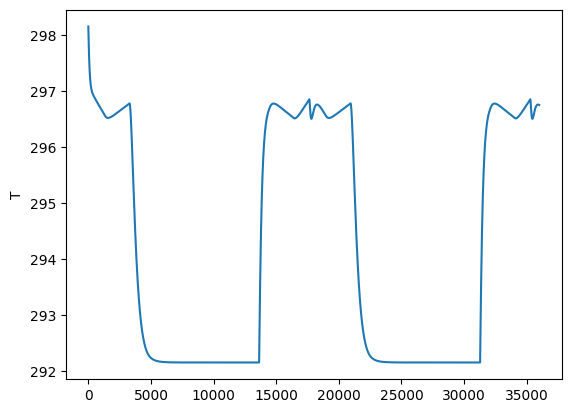

In [38]:
import seaborn as sns
sns.lineplot(df1["T"])

In [ ]:
#Conduct real-time prediction on the temperature:
